In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister ,execute, Aer
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes
from qiskit.primitives import Estimator, Sampler
from qiskit_algorithms.minimum_eigensolvers import VQE 
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit.quantum_info import SparsePauliOp, Pauli, state_fidelity, random_statevector
from qiskit.extensions import RZGate, UnitaryGate
from qiskit.quantum_info import Operator, Statevector
from numpy import sqrt, diag, array,conjugate,transpose, append, dot, abs, pi, linalg, log, sqrt,arange, mean, std, exp
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from random import *

In [2]:
def Hamil_Schw(N,m,x):
    Hamil_Schw = 0
    Hamil_Schw_kin_list= []
    Hamil_Schw_mass_list= []
    Hamil_Schw_gauge_list= []
    for i in range(N-1):
        # Create mass terms
        Hamil_Schw_mass_list.append(("Z", [i], (-1)**(i+1)*m/2))
        if i == (N-2):
            Hamil_Schw_mass_list.append(("Z", [i+1], (-1)**(i+2)*m/2))
        # Create kinematic terms
        Hamil_Schw_kin_list.append((("XX", [i,i+1], x/2)))
        Hamil_Schw_kin_list.append((("YY", [i,i+1], x/2)))
        # Create gauge terms
        if i % 2 ==0:
            for j in range(i+1):
                Hamil_Schw_gauge_list.append(("Z", [j], -1/2))
        for j in range(i):
            for k in range(j+1,i+1):
                Hamil_Schw_gauge_list.append(("ZZ",[j,k],1/2))
    # Get in total
    Hamil_Schw = Hamil_Schw_kin_list+Hamil_Schw_mass_list+Hamil_Schw_gauge_list
    # Create Hamiltonian operator from the defined list
    Hamil_Schw = SparsePauliOp.from_sparse_list(Hamil_Schw, num_qubits=N)
    return Hamil_Schw


In [112]:
N = 5
m = 18
x = 1
del_t = 0.1
M = 200

In [113]:
Hal =  Hamil_Schw(N,m,x)

# Classical solver
w,v = linalg.eig(Hal)
# print("Eigenvectors:",v)
# print("Eigenvalues:", w)

# Find ground state and energy in ensemble solutions
minimum=w[0]
min_spot=0
for i in range(1,2**N):
    if w[i]<minimum:
        min_spot=i
        minimum=w[i]                   
groundstate = v[:,min_spot]
# print("Ground State")
# print(groundstate)
# print("Ground Energy")
# print(minimum)

In [114]:
# Apply first-order Trotter decomposition
def H_evol_1st(qc,n,M,m,x,del_t):
    N = qc.num_qubits
    for i in range(N-1):
        m_0 = 0.1
        # Create mass terms
        qc.rz(((-1)**(i+1)*m*n/M+m_0*(1-n/M))*del_t,i)
        if i == (N-2):
            qc.rz(((-1)**(i+2)*m*n/M+m_0*(1-n/M))*del_t,i+1)
        # Create gauge terms
        if i % 2 ==0:
            for j in range(i+1):
                qc.rz(-1*del_t,j)
        for j in range(i):
            for k in range(j+1,i+1):
                qc.rzz(1*del_t,j,k)
    # Create kinematic terms
    for i in range(N-1):
        qc.rxx(x*n/M*del_t,i,i+1)
        qc.ryy(x*n/M*del_t,i,i+1)
    return qc

In [115]:
# Apply second-order Trotter decomposition
def H_evol_2nd(qc,n,M,m,x,del_t):
    N = qc.num_qubits
    # Create kinematic terms (first layer)
    for i in range(N-1):
        qc.ryy(1/2*x*n/M*del_t,i,i+1)
        qc.rxx(1/2*x*n/M*del_t,i,i+1)
    for i in range(N-1):
        m_0 = 0.1
        # Create mass terms
        qc.rz(((-1)**(i+1)*m*n/M+m_0*(1-n/M))*del_t,i)
        if i == (N-2):
            qc.rz(((-1)**(i+2)*m*n/M+m_0*(1-n/M))*del_t,i+1)
        # Create gauge terms
        if i % 2 ==0:
            for j in range(i+1):
                qc.rz(-1*del_t,j)
        for j in range(i):
            for k in range(j+1,i+1):
                qc.rzz(1*del_t,j,k)
    # Create kinematic terms (second layer)
    for i in range(N-1):
        qc.rxx(1/2*x*n/M*del_t,i,i+1)
        qc.ryy(1/2*x*n/M*del_t,i,i+1)
    return qc

In [116]:
# ground state is |1010...10>
qc = QuantumCircuit(N)
for i in range(qc.num_qubits):
    if i%2 ==1:
        qc.x(i)

for i in range(M):
    qc = H_evol_1st(qc,i,M,m,x,del_t)

In [117]:
# ground state is |1010...10>
qc_2nd = QuantumCircuit(N)
for i in range(qc_2nd.num_qubits):
    if i%2 ==1:
        qc_2nd.x(i)

for i in range(int(M/2)):
    qc_2nd = H_evol_2nd(qc_2nd,i,M,m,x,del_t)

In [118]:
state_fidelity(Statevector(qc),Statevector(groundstate))

0.9760145479304928

In [119]:
state_fidelity(Statevector(qc_2nd),Statevector(groundstate))

0.9990365427678747

In [183]:
N = 7
x = 1
del_t = 0.1
M = 200
fid_1st = []
fid_2nd = []

In [184]:
for m in range(0,5):
    m = m*3
    # Classical solver
    Hal =  Hamil_Schw(N,m,x)
    w,v = linalg.eig(Hal)
    # Find ground state and energy in ensemble solutions
    minimum=w[0]
    min_spot=0
    for i in range(1,2**N):
        if w[i]<minimum:
            min_spot=i
            minimum=w[i]                   
    groundstate = v[:,min_spot]

    # 1_st
    qc = QuantumCircuit(N)
    for i in range(qc.num_qubits):
        if i%2 ==1:
            qc.x(i)
    for i in range(M):
        qc = H_evol_1st(qc,i,M,m,x,del_t)
    fid_1st.append(state_fidelity(Statevector(qc),Statevector(groundstate)))

    # 2-nd
    qc_2nd = QuantumCircuit(N)
    for i in range(qc_2nd.num_qubits):
        if i%2 ==1:
            qc_2nd.x(i)
    for i in range(int(M/2)):
        qc_2nd = H_evol_2nd(qc_2nd,i,M,m,x,del_t)
    fid_2nd.append(state_fidelity(Statevector(qc_2nd),Statevector(groundstate)))

In [187]:
qubit_list = [i*3 for i in range(0,5)]

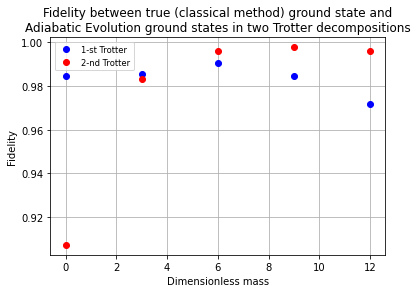

In [189]:
plt.plot(qubit_list, fid_1st, 'bo',label='1-st Trotter')
plt.plot(qubit_list, fid_2nd, 'ro',label='2-nd Trotter')
plt.ylabel('Fidelity')
plt.xlabel('Dimensionless mass')
plt.grid()
plt.legend(loc='best', fontsize = 'small')
plt.title('Fidelity between true (classical method) ground state and\nAdiabatic Evolution ground states in two Trotter decompositions')
plt.show()